# Athritis on heart attack model

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_score
from collections import defaultdict

In [2]:
# import data
data = pd.read_csv("../data/Arthritis_on_heart_attack.csv",usecols=range(1,15))

# obtain an overview of the data
data.info()
data.describe()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3788 entries, 0 to 3787
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   arthritis.type     3788 non-null   object
 1   gender             3788 non-null   object
 2   bmi                3788 non-null   object
 3   diabetes           3788 non-null   object
 4   smoke              3788 non-null   object
 5   age                3788 non-null   object
 6   education          3788 non-null   object
 7   marriage           3788 non-null   object
 8   physical.activity  3788 non-null   object
 9   medical.access     3788 non-null   object
 10  blood.pressure     3788 non-null   object
 11  healthy.diet       3788 non-null   object
 12  covered.health     3788 non-null   object
 13  heart.attack       3788 non-null   object
dtypes: object(14)
memory usage: 414.4+ KB


,arthritis.type,gender,bmi,diabetes,smoke,age,education,marriage,physical.activity,medical.access,blood.pressure,healthy.diet,covered.health,heart.attack
0,Non-arthritis,Male,"(25,80]",No,No,"(50,70]",School,Married,Moderate,Yes,No,Fair,No,No
1,Non-arthritis,Male,"(0,25]",No,No,"(19.9,50]",High.School,Not.married,No,Yes,No,Good,No,No
2,Non-arthritis,Male,"(25,80]",No,Yes,"(50,70]",High.School,Married,No,Yes,Yes,Good,Yes,No
3,Rheumatoid arthritis,Male,"(25,80]",Yes,No,"(50,70]",College,Married,No,Yes,Yes,Poor,Yes,No
4,Non-arthritis,Female,"(25,80]",No,No,"(19.9,50]",High.School,Married,Moderate,No,No,Fair,No,No


In [3]:
# print frequency distributions crosstabs
for col in data:
    data_crosstab = pd.crosstab(data['heart.attack'],
                            data[col], 
                               margins = False)
    print(data_crosstab,"\n")


arthritis.type  Non-arthritis  Rheumatoid arthritis
heart.attack                                       
No                       3454                   224
Yes                        90                    20 

gender        Female  Male
heart.attack              
No              1825  1853
Yes               25    85 

bmi           (0,25]  (25,80]
heart.attack                 
No              1152     2526
Yes               24       86 

diabetes        No  Yes
heart.attack           
No            3378  300
Yes             84   26 

smoke           No   Yes
heart.attack            
No            2073  1605
Yes             31    79 

age           (19.9,50]  (50,70]  (70,81]
heart.attack                             
No                 2316      982      380
Yes                  24       39       47 

education     College  High.School  School
heart.attack                              
No               1733         1541     404
Yes                42           44      24 

marriage      

Die Gruppe der Personen mit Herzinfarkt ist sehr niedrig besetzt mit 110/3678=0.0299075, damit ist der Datensatz moderat bis sehr startk unausgeglichen. 
Dementsprechend kann es sinnvoll sein Methoden wie gewichtetes Sampling,threshhold-moving, oversampling, undersampling oder SMOTE zur Verbesserung der Model Performance anzuwenden.

F1-Score ist ein sinnvoller Scorer für Modelle auf einen unausgeglichenen Datensatz. Da eine leistungsfähige Vorhersage der positiven Klasse 'heart.attack' von hoeherer Relevanz ist sollten hier F0.5-Score und PR AUC bzw. average_precision benutzt werden.

In [4]:
# encode categorical data for modeling
label_dict = defaultdict(LabelEncoder)
data.apply(lambda x: label_dict[x.name].fit_transform(x))

for i in label_dict:
    print(label_dict[i].classes_)
    
# manually setting encoder for healthy.diet for a more reasonable order
label_dict['healthy.diet'].classes_ = ['Good', 'Fair', 'Poor']

# non-binary categories exhibit natural order and are therefore encoded ordinaly 
encoded_data = data.apply(lambda x: label_dict[x.name].transform(x))
encoded_data.head()

['Non-arthritis' 'Rheumatoid arthritis']
['Female' 'Male']
['(0,25]' '(25,80]']
['No' 'Yes']
['No' 'Yes']
['(19.9,50]' '(50,70]' '(70,81]']
['College' 'High.School' 'School']
['Married' 'Not.married']
['High' 'Moderate' 'No']
['No' 'Yes']
['No' 'Yes']
['Fair' 'Good' 'Poor']
['No' 'Yes']
['No' 'Yes']


,arthritis.type,gender,bmi,diabetes,smoke,age,education,marriage,physical.activity,medical.access,blood.pressure,healthy.diet,covered.health,heart.attack
0,0,1,1,0,0,1,2,0,1,1,0,1,0,0
1,0,1,0,0,0,0,1,1,2,1,0,0,0,0
2,0,1,1,0,1,1,1,0,2,1,1,0,1,0
3,1,1,1,1,0,1,0,0,2,1,1,2,1,0
4,0,0,1,0,0,0,1,0,1,0,0,1,0,0


In [5]:
from sklearn.feature_selection import chi2

chi2(encoded_data.loc[:, encoded_data.columns != 'heart.attack'],encoded_data[['heart.attack']])

(array([2.42425701e+01, 1.50973112e+01, 1.39884606e+00, 2.97382272e+01,
        1.90789571e+01, 1.16714793e+02, 6.47822113e+00, 1.05688353e-01,
        1.39044315e+00, 1.27303002e+00, 6.88725679e+01, 9.41227337e-01,
        3.64724397e+00]),
 array([8.49340896e-07, 1.02108622e-04, 2.36916873e-01, 4.94500196e-08,
        1.25420175e-05, 3.31464790e-27, 1.09204222e-02, 7.45107318e-01,
        2.38330276e-01, 2.59199018e-01, 1.05035733e-16, 3.31962402e-01,
        5.61620742e-02]))

Zum testen der Abhaengigkeit zwischen kategorischen Variablen kann der Chi-Quadrat-Test angewandt, Merkmalsinteraktionen werden bei diesem Test ignoriert. Wenn man beim p-Wert von einem Signifikanzniveau von 0.05 ausgeht, wuerde man sich fuer die Variablen 'athritis.type', 'gender', 'diabetes', 'smoke', 'age', 'education', 'blood.pressure'. 

Daraus kann man schließen, dass die gegebenen Merkmale geeignet sind um einen Herzinfarkt zu prognostizieren.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

y = encoded_data['heart.attack']
X = encoded_data.drop('heart.attack',axis=1)

# stratified train test split over heart.attack 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y)

Zunaechst wird ein logistisches Regressionsmodell genutzt, weil es für binäre Klassifizierung geeignet ist und in der Lage ist durch eine interne Gewichtung ein relativ gutes Model auf dem unausgeglichenen Daten zu generieren. Durch den l1-Regulator werden Koeffizienten von nicht-relevanten Merkmalen gegen Null reduziert und der l2-Regulator verminder overfitting.

In [102]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
from sklearn.metrics import fbeta_score, make_scorer
f05_scorer = make_scorer(fbeta_score, beta=0.5)

scorer = f05_scorer
# create model
lr_balanced = LogisticRegression(class_weight='balanced')

scores = cross_val_score(lr_balanced, X_train, y_train, scoring=scorer, cv=5, n_jobs=1)
print('F0.5-Score: %.3f' % (mean(scores)))

Score: 0.098


In [218]:
f05_scorer

make_scorer(fbeta_score, beta=0.5)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best score:  0.24339024580205876


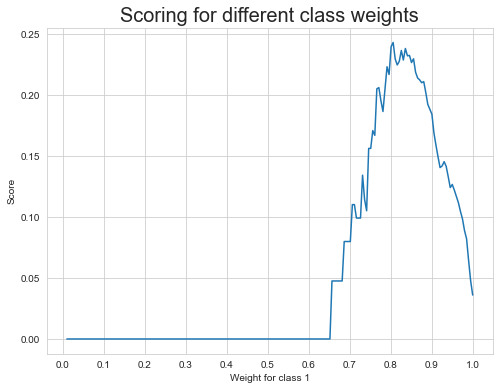

In [165]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

lr = LogisticRegression()
# Setting the range for class weights
weights = np.linspace(0.0,0.99,200)
# Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

# Fitting grid search to the train data with 5 folds
lr_weight_gridsearch = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring=scorer, 
                          verbose=2).fit(X_train, y_train)
                          # Ploting the score for different values of weight
                          
sns.set_style('whitegrid')
plt.figure(figsize=(8,6))
weigh_data = pd.DataFrame({ 'score': lr_weight_gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(x=weigh_data['weight'],y= weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('Score')
plt.xticks(np.linspace(0,1,11))
plt.title('Scoring for different class weights', fontsize=20)

lr_weighted = lr_weight_gridsearch.best_estimator_

print('Best F0.5-Score score: ', lr_weight_gridsearch.best_score_)

In [183]:

regulizer_param_grid = {'C' : (np.arange(0.7,1,0.01)),
            'l1_ratio': [0,0.5,0.6,0.7,0.8,0.9,0.99,1,0.9999]}

lr_regulizer_gridsearch = GridSearchCV(estimator= lr_weighted.set_params(solver='saga',penalty='elasticnet'), 
                          param_grid= regulizer_param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring=scorer, 
                          verbose=2).fit(X_train, y_train)

Fitting 5 folds for each of 279 candidates, totalling 1395 fits


In [189]:
# get final logistical regression model
lr_model = lr_regulizer_gridsearch.best_estimator_
lr_model.fit(X_train,y_train)

print(lr_model.coef_)

y_pred = lr_model.predict(X_test)
print(classification_report(y_test, y_pred))
pd.crosstab(y_test,y_pred)

[[0.42579421 1.02201744 0.12580956 0.39637712 0.71863015 0.8901837
  0.09972789 0.10668788 0.         0.         1.1353409  0.13916151
  0.10961992]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       736
           1       0.27      0.18      0.22        22

    accuracy                           0.96       758
   macro avg       0.62      0.58      0.60       758
weighted avg       0.96      0.96      0.96       758



col_0,0,1
heart.attack,,
0,725,11
1,18,4


PR-AUC : 0.152
Best Threshold=0.353207, F-Score=0.303


c:\Users\David\Documents\Bullshit_Jobs\2021NovemberNachBsc\angenommen\Ingef\PropensityScoreMatching\env\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


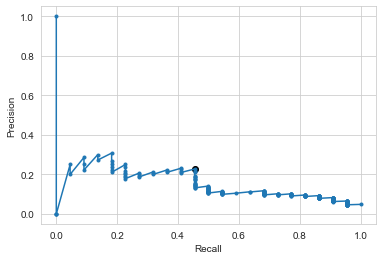

In [186]:
# get prediction probabilities for scoring
pos_proba = lr_model.predict_proba(X_test)[:,1]

from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(y_test, pos_proba)

auc_precision_recall = auc(recall, precision)

print('PR-AUC : %.3f' % (auc_precision_recall))

# optimize threshold
fscore = (2 * precision * recall) / (precision + recall)
idx = np.nanargmax(fscore)

print('Best Threshold=%f, F-Score=%.3f' % (thresholds[idx], fscore[idx]))

plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.scatter(recall[idx], precision[idx], marker='o', color='black', label='Best')

In [194]:
y_pred_thresh = (lr_model.predict_proba(X_test)[:,1]>0.353207).astype(bool)
print(classification_report(y_test,y_pred_thresh))
pd.crosstab(y_test,y_pred_thresh)

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       736
           1       0.21      0.41      0.28        22

    accuracy                           0.94       758
   macro avg       0.60      0.68      0.62       758
weighted avg       0.96      0.94      0.95       758



col_0,False,True
heart.attack,,
0,702,34
1,13,9


In [206]:
from sklearn import svm


min_max_scaler = MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(encoded_data)

svc = svm.SVC(gamma='scale',class_weight='balanced')
scores = cross_val_score(svc, X_train, y_train, scoring=scorer, cv=10, n_jobs=1)
print('F0.5-Score : %.3f (%.3f)' % (mean(scores), std(scores)))



Score: 0.099 (0.024)


In [214]:
# Setting the range for class weights
weights = np.linspace(0.0,0.99,20)
# Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=svm.SVC(gamma='scale'), param_grid=param_grid, n_jobs=-1, cv=cv, scoring=scorer)

grid.fit(X_train,y_train)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1),
             estimator=SVC(), n_jobs=-1,
             param_grid={'class_weight': [{0: 0.0, 1: 1.0},
                                          {0: 0.004974874371859297,
                                           1: 0.9950251256281407},
                                          {0: 0.009949748743718593,
                                           1: 0.9900502512562814},
                                          {0: 0.014924623115577889,
                                           1: 0.9850753768844221},
                                          {0: 0.019899497487437186,
                                           1: 0.9801005025125629},
                                          {0: 0.0248743718592...
                                          {0: 0.11442211055276383,
                                           1: 0.8855778894472361},
                                          {0: 0.11939698492462311,
          

In [213]:
grid.best_estimator_

SVC(class_weight={0: 0.11442211055276383, 1: 0.8855778894472361})

In [211]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold 

rf_model = RandomForestClassifier(n_estimators=1000)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

scores = cross_val_score(rf_model, X_train, y_train, scoring=scorer, cv=cv, n_jobs=-1)

print('Score: %.3f (%.3f)' % (mean(scores), std(scores)))



Score: 0.018 (0.067)


In [215]:
rf_grid = GridSearchCV(estimator=RandomForestClassifier(n_estimators=1000), param_grid=param_grid, n_jobs=-1, cv=cv, scoring=scorer).fit(X_train,y_train)
best_rf_model = rf_grid.best_estimator_



NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [217]:
rf_grid.best_score_

0.13960119316424668